# Chapter 6 - CellBender Basic Analysis

## Objective

In this chapter, we load all single-nucleus RNA-seq datasets required for benchmarking the **Singulator + FACS** and **Singulator + LeviCell** protocols. We also verify metadata consistency, perform basic integrity checks, and prepare the data objects for downstream analysis.

This includes:

- Locating the data on the shared filesystem (Iris)
- Loading raw count matrices (e.g., `filtered_feature_bc_matrix.h5` from 10X)
- Loading data into `AnnData` objects

## Data Source

The data for this benchmarking project is stored on the **Iris** HPC filesystem under:

`/data1/collab002/sail/isabl/datalake/prod/010/collaborators/SAIL/projects/singulator_debris_removal_and/experiments`

We will be working with the data under identifier `MB-4027_*`


## Core Imports

In [5]:
import os
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable, Dict, List
from cellbender.remove_background.downstream import (
    load_anndata_from_input_and_output,
    anndata_from_h5,
)

## File Paths and Metadata

In [6]:
# Constants
DATA_DIR = "./data"
READ_ONLY_DIR = os.path.join(DATA_DIR, "read_only")
FIGURES_OUTPUT_DIR = os.path.join(DATA_DIR, "figures", "chapter_09_plateau_analysis")
RAW_FEATURE_BC_MATRIX_FILE_NAME = "raw_feature_bc_matrix.h5"

GENE_SETS_DIR = os.path.join(DATA_DIR, "gene_sets_and_info")

# Make sure figures output directory exists
os.makedirs(FIGURES_OUTPUT_DIR, exist_ok=True)

ANALYSIS_DIR = os.path.join(DATA_DIR, "analysis")
INPUT_ADATA_DIR = os.path.join(ANALYSIS_DIR, "adatas", "cell_bender_corrected")
OUTPUT_ADATA_DIR = os.path.join(ANALYSIS_DIR, "adatas", "chapter_09_plateau_analysis")

# Make sure output adata dir directory exists
os.makedirs(OUTPUT_ADATA_DIR, exist_ok=True)

# Sample metadata - in data/metadata.tsv
samples = {
    "SF_N": ("MB-4027_SF_N", "Normal Colon", "Singulator+FACS"),
    "SL_N": ("MB-4027_SL_N", "Normal Colon", "Singulator+LeviCell"),
    "SF_T": ("MB-4027_SF_T", "Tumor Colon", "Singulator+FACS"),
    "SL_T": ("MB-4027_SL_T", "Tumor Colon", "Singulator+LeviCell"),
    "SF_LN": ("MB-4027_SF_LN", "Normal Liver", "Singulator+FACS"),
    "SL_LN": ("MB-4027_SL_LN", "Normal Liver", "Singulator+LeviCell"),
}

# Color palette for plotting
protocol_color_palette = {
    "Singulator+FACS": "#AEC6CF",
    "Singulator+LeviCell": "#FFDAB9",
}

### Read in AnnDatas

In [13]:
# Load AnnData objects
adatas_raw = {}
adatas_cellbender = {}
adatas_combined = {}
adata_metadata = {}
adata_tissues = []

for key, (folder, tissue, protocol) in samples.items():
    input_file_path = os.path.join(
        READ_ONLY_DIR,
        folder,
        f"analyses/CellRangerGex-9.0.0-{folder}/outputs",
        RAW_FEATURE_BC_MATRIX_FILE_NAME,
    )
    output_file_path = os.path.join(
        INPUT_ADATA_DIR, f"{key}_cell_bender_corrected_output.h5"
    )

    adatas_raw[key] = sc.read_10x_h5(input_file_path)
    adatas_cellbender[key] = anndata_from_h5(output_file_path)

    adatas_combined[key] = load_anndata_from_input_and_output(
        input_file=input_file_path, output_file=output_file_path, input_layer_key="raw"
    )

    adata_metadata[key] = (tissue, protocol)
    adata_tissues.append(tissue)

/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_te

### Get Plateaus

In [20]:
plateau_adatas = {}
empty_droplet_adatas = {}
high_background_fraction_adatas = {}

for key, (folder, tissue, protocol) in samples.items():
    adata_raw = adatas_raw[key].copy()
    adata_cellbender = adatas_cellbender[key].copy()
    adata_combined = adatas_combined[key].copy()

    # Subset to droplets with low cell probability (< 0.1)
    empty_droplet_adata = adata_combined[adata_combined.obs["cell_probability"] < 0.1]
    empty_droplet_adatas[key] = empty_droplet_adata

    print(f"{key} — Empty droplets:", empty_droplet_adata)

    # Subset to droplets with background_fraction > 0.5
    high_bg_adata = adata_combined[adata_combined.obs["background_fraction"] > 0.5]
    high_background_fraction_adatas[key] = high_bg_adata

    print(f"{key} — High background_fraction droplets:", high_bg_adata)

    # Subset to top 6000 barcodes by UMI count
    counts = np.array(adata_combined.X.sum(axis=1)).flatten()
    sorted_idx = np.argsort(counts)[:6000]  # Highest counts first

    top_cells = adata_combined.obs_names[sorted_idx]
    plateau_adata = adata_combined[top_cells].copy()

    print(f"{key} — Plateau adata:", plateau_adata)
    plateau_adatas[key] = plateau_adata

from pprint import pprint

pprint(plateau_adatas)

/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


SF_N — Empty droplets: View of AnnData object with n_obs × n_vars = 4756 × 38606
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_raw', 'n_cellbender'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed', 'n_raw', 'n_cellbender'
    uns: 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'swapping_fraction_dist_params', 'estimator', 'features_analyzed_inds', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_learning_rate_value', 'learning_curve_test_elbo', 'learning_curve_test_epoch', 'learning_curve_train_elbo', 'learning_curve_train_epoch', 'target_false_positive_rate'
    obsm: 'cellbender_embedding'
    layers: 'raw', 'cellbender'
SF_N — High background_fraction droplets: View of AnnData object with n_obs × n_vars = 1888 × 38606
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_r

/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


SL_N — Empty droplets: View of AnnData object with n_obs × n_vars = 4646 × 38606
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_raw', 'n_cellbender'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed', 'n_raw', 'n_cellbender'
    uns: 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'swapping_fraction_dist_params', 'estimator', 'features_analyzed_inds', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_learning_rate_value', 'learning_curve_test_elbo', 'learning_curve_test_epoch', 'learning_curve_train_elbo', 'learning_curve_train_epoch', 'target_false_positive_rate'
    obsm: 'cellbender_embedding'
    layers: 'raw', 'cellbender'
SL_N — High background_fraction droplets: View of AnnData object with n_obs × n_vars = 2271 × 38606
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_r

/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


SF_T — Empty droplets: View of AnnData object with n_obs × n_vars = 4583 × 38606
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_raw', 'n_cellbender'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed', 'n_raw', 'n_cellbender'
    uns: 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'swapping_fraction_dist_params', 'estimator', 'features_analyzed_inds', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_learning_rate_value', 'learning_curve_test_elbo', 'learning_curve_test_epoch', 'learning_curve_train_elbo', 'learning_curve_train_epoch', 'target_false_positive_rate'
    obsm: 'cellbender_embedding'
    layers: 'raw', 'cellbender'
SF_T — High background_fraction droplets: View of AnnData object with n_obs × n_vars = 1578 × 38606
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_r

/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


SL_T — Empty droplets: View of AnnData object with n_obs × n_vars = 4526 × 38606
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_raw', 'n_cellbender'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed', 'n_raw', 'n_cellbender'
    uns: 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'swapping_fraction_dist_params', 'estimator', 'features_analyzed_inds', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_learning_rate_value', 'learning_curve_test_elbo', 'learning_curve_test_epoch', 'learning_curve_train_elbo', 'learning_curve_train_epoch', 'target_false_positive_rate'
    obsm: 'cellbender_embedding'
    layers: 'raw', 'cellbender'
SL_T — High background_fraction droplets: View of AnnData object with n_obs × n_vars = 2223 × 38606
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_r

/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


SF_LN — Empty droplets: View of AnnData object with n_obs × n_vars = 4701 × 38606
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_raw', 'n_cellbender'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed', 'n_raw', 'n_cellbender'
    uns: 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'swapping_fraction_dist_params', 'estimator', 'features_analyzed_inds', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_learning_rate_value', 'learning_curve_test_elbo', 'learning_curve_test_epoch', 'learning_curve_train_elbo', 'learning_curve_train_epoch', 'target_false_positive_rate'
    obsm: 'cellbender_embedding'
    layers: 'raw', 'cellbender'
SF_LN — High background_fraction droplets: View of AnnData object with n_obs × n_vars = 772 × 38606
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_

/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


SL_LN — Empty droplets: View of AnnData object with n_obs × n_vars = 4915 × 38606
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_raw', 'n_cellbender'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed', 'n_raw', 'n_cellbender'
    uns: 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'swapping_fraction_dist_params', 'estimator', 'features_analyzed_inds', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_learning_rate_value', 'learning_curve_test_elbo', 'learning_curve_test_epoch', 'learning_curve_train_elbo', 'learning_curve_train_epoch', 'target_false_positive_rate'
    obsm: 'cellbender_embedding'
    layers: 'raw', 'cellbender'
SL_LN — High background_fraction droplets: View of AnnData object with n_obs × n_vars = 1728 × 38606
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n

### Calculate QC Metrics

In [21]:
def run_qc_metrics(adata) -> None:
    """
    Compute standard quality control (QC) metrics on an AnnData object.

    Args:
        adata (AnnData): Annotated data matrix of shape n_obs x n_vars.

    Returns:
        None: Modifies the input AnnData object in-place by adding QC metrics to `adata.obs` and `adata.var`.
    """

    sc.pp.calculate_qc_metrics(
        adata,
        inplace=True,
        percent_top=None,
    )

    adata.var_names_make_unique()
    adata.obs_names_make_unique()

    print(adata)

    return


# Run QC metrics on each dataset
for adata in plateau_adatas.values():
    run_qc_metrics(adata)
    print(adata)

for adata in empty_droplet_adatas.values():
    run_qc_metrics(adata)
    print(adata)

for adata in high_background_fraction_adatas.values():
    run_qc_metrics(adata)
    print(adata)

AnnData object with n_obs × n_vars = 6000 × 38606
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_raw', 'n_cellbender', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed', 'n_raw', 'n_cellbender', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'swapping_fraction_dist_params', 'estimator', 'features_analyzed_inds', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_learning_rate_value', 'learning_curve_test_elbo', 'learning_curve_test_epoch', 'learning_curve_train_elbo', 'learning_curve_train_epoch', 'target_false_positive_rate'
    obsm: 'cellbender_embedding'
    layers: 'raw', 'cellbender'
AnnData object w

/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/scanpy/preprocessing/_qc.py:145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/scanpy/preprocessing/_qc.py:145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actua

AnnData object with n_obs × n_vars = 4915 × 38606
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_raw', 'n_cellbender', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed', 'n_raw', 'n_cellbender', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'swapping_fraction_dist_params', 'estimator', 'features_analyzed_inds', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_learning_rate_value', 'learning_curve_test_elbo', 'learning_curve_test_epoch', 'learning_curve_train_elbo', 'learning_curve_train_epoch', 'target_false_positive_rate'
    obsm: 'cellbender_embedding'
    layers: 'raw', 'cellbender'
AnnData object w

/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/scanpy/preprocessing/_qc.py:145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  ut

## Plotting Functions

In [6]:
# Function to plot a scalar metric from multiple AnnData objects and create a subplot for each unique tissue.
def adaptive_formatter(x, _):
    """
    Formats large numeric values for axis tick labels using adaptive human-readable notation.

    - Values ≥ 1,000,000 are shown with 'M' (e.g., 2,500,000 → '2.5M')
    - Values < 1,000,000 are shown as plain integers (e.g., 42,000 → '42000')
    """
    if x >= 1e6:
        return f"{x / 1e6:.1f}M"
    else:
        return f"{int(x)}"


def plot_adata_scalar_metric(
    adatas: dict,
    adata_metadata: dict,
    metric_func: Callable,
    metric_label: str,
    protocol_color_palette: dict,
) -> None:
    """
    Plots a scalar metric computed on each AnnData object, grouped by tissue and protocol. Will create as many subplots as there are unique tissues.
    The metric function should return a scalar value for each AnnData object.
    The metric label is used for the Y-axis and title, and the color palette maps protocol names to colors.
    The function uses adaptive formatting for the Y-axis to handle large numbers (e.g., millions and thousands).
    It also annotates the bars with the actual values for clarity.

    Args:
        adatas: dict of AnnData objects keyed by sample ID
        adata_metadata: dict of (tissue, protocol) tuples keyed by sample ID
        metric_func: function that takes an AnnData object and returns a scalar
        metric_label: label to show on the Y-axis and title (e.g., "Total Reads")
        protocol_color_palette: mapping of protocol name to color
    Returns:
        fig: matplotlib figure object containing the plot
    """
    # Assemble data
    rows = []
    for key, adata in adatas.items():
        tissue, protocol = adata_metadata[key]
        value = metric_func(adata)
        rows.append({"Tissue": tissue, "Protocol": protocol, "Value": value})
    df = pd.DataFrame(rows)

    # Determine unique tissues (to define subplots)
    unique_tissues = df["Tissue"].unique()

    # Plot setup
    sns.set_theme(style="white", font_scale=1.1)
    fig, axes = plt.subplots(
        1, len(unique_tissues), figsize=(5 * len(unique_tissues), 5), sharey=True
    )

    if len(unique_tissues) == 1:
        axes = [axes]  # Ensure axes is always iterable

    for i, tissue in enumerate(unique_tissues):
        ax = axes[i]
        sns.barplot(
            data=df[df["Tissue"] == tissue],
            x="Protocol",
            y="Value",
            hue="Protocol",
            palette=protocol_color_palette,
            legend=False,
            ax=ax,
        )
        ax.set_title(tissue, fontsize=13, weight="bold")
        ax.set_xlabel("")
        ax.set_ylabel(metric_label if i == 0 else "")
        ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(adaptive_formatter))

        for p in ax.patches:
            val = p.get_height()
            ax.annotate(
                f"{int(val):,}",
                (p.get_x() + p.get_width() / 2.0, val),
                ha="center",
                va="bottom",
                fontsize=10,
                weight="bold",
            )

    plt.suptitle(
        f"{metric_label} by Protocol Across Tissues", fontsize=16, weight="bold"
    )
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    legend_elements = [
        mpl.patches.Patch(facecolor=color, label=label)
        for label, color in protocol_color_palette.items()
    ]
    fig.legend(
        handles=legend_elements,
        title="Protocol",
        loc="upper right",
        bbox_to_anchor=(1.05, 1.05),
    )
    return fig

In [69]:
# Function to plot a metric distribution from multiple AnnData objects and create a subplot for each unique tissue.


def plot_adata_metric_histogram(
    adatas: Dict[str, sc.AnnData],
    adata_metadata: Dict[str, tuple],
    field: str,
    axis: str = "obs",
    bins: int = 100,
    x_label: str = None,
    log_x: bool = True,
    log_y: bool = False,
    title: str = "Distribution by Protocol Across Tissues",
    row_label: str = "Cell",
    protocol_color_palette: Dict[str, str] = None,
    proportion: bool = False,
) -> None:
    """
    Plots the distribution of a field (column) from each AnnData object, grouped by tissue and protocol.
    """
    # Gather data
    rows = []
    for key, adata in adatas.items():
        tissue, protocol = adata_metadata[key]
        values = getattr(adata, axis)[field]
        if log_x:
            values = np.log1p(values)
        for val in values:
            rows.append({"Tissue": tissue, "Protocol": protocol, "Value": val})

        df = pd.DataFrame(rows)

        print(df["Value"].describe())

    # Unique tissues
    unique_tissues = df["Tissue"].unique()

    # Plot
    sns.set_theme(style="white", font_scale=1.1)
    fig, axes = plt.subplots(
        1, len(unique_tissues), figsize=(5 * len(unique_tissues), 5), sharey=True
    )
    if len(unique_tissues) == 1:
        axes = [axes]

    stat_type = "probability" if proportion else "count"

    for i, tissue in enumerate(unique_tissues):
        ax = axes[i]
        sns.histplot(
            data=df[df["Tissue"] == tissue],
            x="Value",
            hue="Protocol",
            palette=protocol_color_palette,
            bins=bins,
            element="step",
            stat=stat_type,
            common_norm=False,
            legend=False,
            ax=ax,
        )
        if log_y:
            ax.set_yscale("log")

        ax.set_title(tissue, fontsize=13, weight="bold")
        ax.set_xlabel(x_label or (f"log1p({field})" if log_x else field))
        if i == 0:
            ax.set_ylabel(f"{row_label} {'Proportion' if proportion else 'Count'}")
        else:
            ax.set_ylabel("")

    # Axis scaling
    if log_x:
        raw_values = np.concatenate(
            [getattr(adatas[key], axis)[field].to_numpy() for key in adatas]
        )
        raw_values = raw_values[raw_values > 0]
        vmin, vmax = raw_values.min(), raw_values.max()
        min_exp, max_exp = int(np.floor(np.log10(vmin))), int(np.ceil(np.log10(vmax)))
        xticks_raw = [10**e for e in range(min_exp, max_exp + 1)]
        xticks_log = np.log1p(xticks_raw)

        for ax in axes:
            ax.set_xlim(np.log1p(vmin), np.log1p(vmax))
            ax.set_xticks(xticks_log)
            ax.set_xticklabels([f"{x:,}" for x in xticks_raw])
    else:
        all_values = np.concatenate(
            [getattr(adatas[key], axis)[field].to_numpy() for key in adatas]
        )
        all_values = all_values[np.isfinite(all_values)]
        vmin, vmax = all_values.min(), all_values.max()
        for ax in axes:
            ax.set_xlim(vmin, vmax)

    # Finalize
    plt.suptitle(title, fontsize=16, weight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    legend_elements = [
        mpl.patches.Patch(facecolor=color, label=label)
        for label, color in protocol_color_palette.items()
    ]
    fig.legend(
        handles=legend_elements,
        title="Protocol",
        loc="upper right",
        bbox_to_anchor=(1.05, 1.05),
    )
    return fig

In [8]:
# Function to plot a metric distribution from multiple AnnData objects and create a subplot for each unique tissue. Same as histogram but uses
# violin plots.


def plot_adata_metric_violin(
    adatas: Dict[str, sc.AnnData],
    adata_metadata: Dict[str, tuple],
    field: str,
    axis: str = "obs",
    log_y: bool = True,
    title: str = "Distribution by Protocol Across Tissues",
    y_label: str = "Value",
    protocol_color_palette: Dict[str, str] = None,
) -> None:
    """
    Plots a violin distribution of a given .obs or .var field from each AnnData object,
    grouped by tissue and protocol. One subplot is generated per tissue.

    Args:
        adatas: Dictionary of AnnData objects keyed by sample ID (e.g., 'sf_ln').
        adata_metadata: Dictionary mapping sample ID to (tissue, protocol) tuples.
        field: Column name to plot from .obs or .var (e.g., 'total_counts').
        axis: Whether to pull from .obs or .var (default: 'obs').
        log_y: Whether to apply log1p transformation to the y-axis values (default: True).
        title: Title of the entire figure.
        y_label: Label for the y-axis.
        protocol_color_palette: Optional dictionary mapping protocol names to colors.
    """
    # Assemble data
    rows = []
    for key, adata in adatas.items():
        tissue, protocol = adata_metadata[key]
        values = getattr(adata, axis)[field]
        if log_y:
            values = np.log1p(values)
        for val in values:
            rows.append({"Tissue": tissue, "Protocol": protocol, "Value": val})
    df = pd.DataFrame(rows)

    # Get unique tissues
    unique_tissues = df["Tissue"].unique()

    # Setup plot grid
    sns.set_theme(style="white", font_scale=1.1)
    fig, axes = plt.subplots(
        1, len(unique_tissues), figsize=(5 * len(unique_tissues), 5), sharey=True
    )
    if len(unique_tissues) == 1:
        axes = [axes]

    for i, tissue in enumerate(unique_tissues):
        ax = axes[i]
        sns.violinplot(
            data=df[df["Tissue"] == tissue],
            x="Protocol",
            y="Value",
            hue="Protocol",
            palette=protocol_color_palette,
            ax=ax,
            linewidth=1,
        )
        ax.set_title(tissue, fontsize=13, weight="bold")
        ax.set_xlabel("")
        ax.set_ylabel(y_label if i == 0 else "")

    plt.suptitle(title, fontsize=16, weight="bold")

    # Custom y-axis ticks if log-transformed
    if log_y:
        raw_values = np.concatenate(
            [getattr(adatas[key], axis)[field].to_numpy() for key in adatas]
        )
        raw_values = raw_values[raw_values > 0]

        ymin = raw_values.min()
        ymax = raw_values.max()
        min_exp = int(np.floor(np.log10(ymin)))
        max_exp = int(np.ceil(np.log10(ymax)))
        yticks_raw = [10**e for e in range(min_exp, max_exp + 1)]
        yticks_log = np.log1p(yticks_raw)

        for ax in axes:
            ax.set_ylim(np.log1p(ymin), np.log1p(ymax))
            ax.set_yticks(yticks_log)
            ax.set_yticklabels([f"{y:,}" for y in yticks_raw])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    return fig

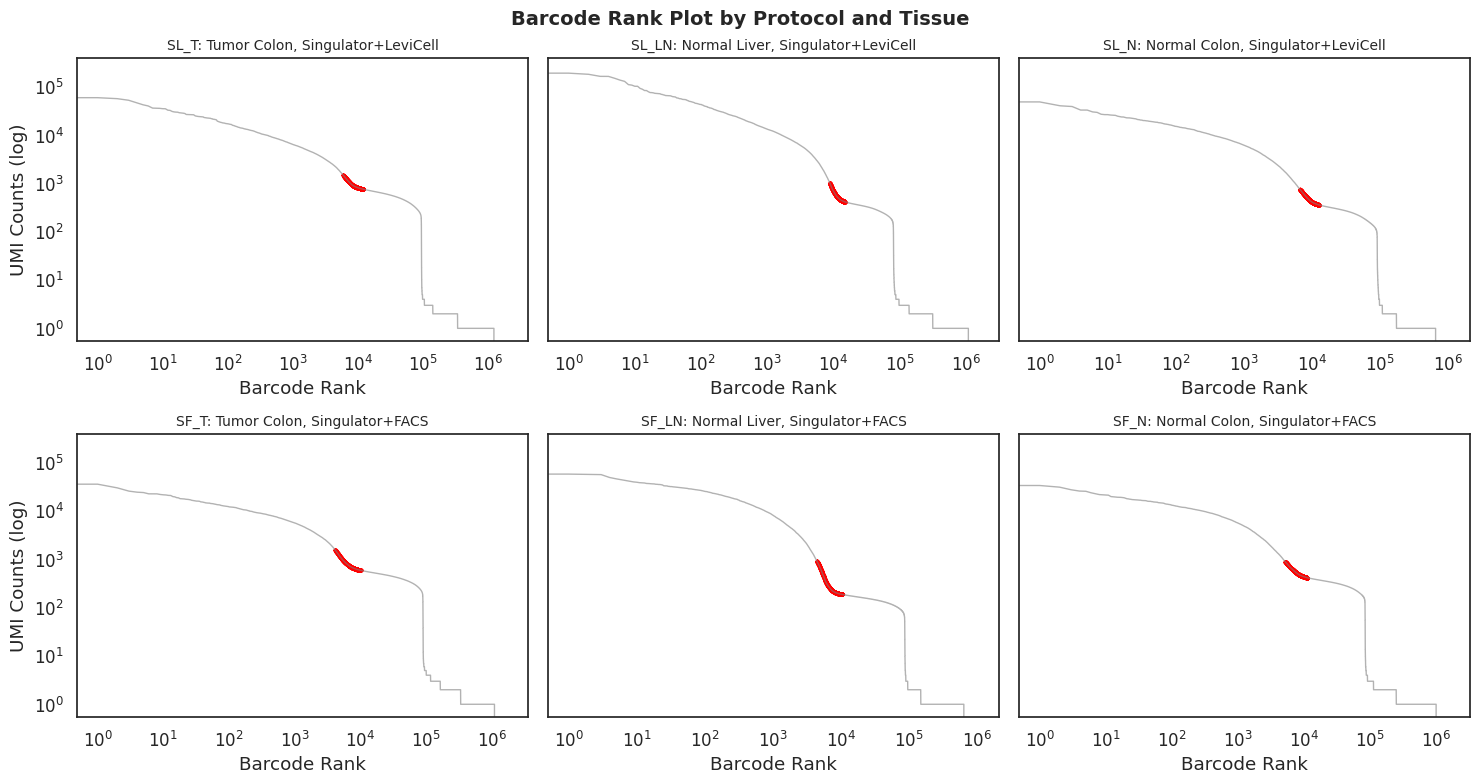

In [87]:
import matplotlib.pyplot as plt
import numpy as np


def plot_barcode_rank_by_protocol_and_tissue(
    adatas: dict,
    plateau_adatas: dict,
    adata_metadata: dict,  # {key: (tissue, protocol)}
):
    tissues = list(set(tissue for tissue, _ in adata_metadata.values()))
    protocols = list(set(protocol for _, protocol in adata_metadata.values()))

    nrows = len(protocols)
    ncols = len(tissues)

    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), sharey=True)
    if nrows == 1:
        axes = np.expand_dims(axes, 0)
    if ncols == 1:
        axes = np.expand_dims(axes, 1)

    for key, adata in adatas.items():
        tissue, protocol = adata_metadata[key]
        row = protocols.index(protocol)
        col = tissues.index(tissue)
        ax = axes[row, col]

        # Use raw layer if present
        counts = (
            np.array(adata.layers["raw"].sum(axis=1)).flatten()
            if "raw" in adata.layers
            else np.array(adata.X.sum(axis=1)).flatten()
        )

        sorted_idx = np.argsort(-counts)
        sorted_counts = counts[sorted_idx]
        sorted_barcodes = adata.obs_names[sorted_idx]

        ax.plot(
            np.arange(len(sorted_counts)),
            sorted_counts,
            color="gray",
            linewidth=1,
            label="All droplets",
            alpha=0.6,
        )

        # Highlight plateau droplets
        if key in plateau_adatas:
            plateau_barcodes = plateau_adatas[key].obs_names

            plateau_set = set(plateau_barcodes)
            plateau_indices = [
                i for i, bc in enumerate(sorted_barcodes) if bc in plateau_set
            ]
            ax.scatter(
                plateau_indices,
                sorted_counts[plateau_indices],
                color="red",
                s=2,
                label="Plateau droplets",
                alpha=0.6,
            )

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("Barcode Rank")
        if col == 0:
            ax.set_ylabel("UMI Counts (log)")
        ax.set_title(f"{key}: {tissue}, {protocol}", fontsize=10)

    plt.tight_layout()
    fig.subplots_adjust(top=0.92)
    fig.suptitle("Barcode Rank Plot by Protocol and Tissue", fontsize=14, weight="bold")
    return fig


# Usage:
# fig = plot_barcode_rank_by_protocol_and_tissue(
#     adatas=raw_adatas_no_cellbender,
#     plateau_adatas=plateau_adatas,
#     adata_metadata=adata_metadata
# )

fig = plot_barcode_rank_by_protocol_and_tissue(
    adatas=raw_adatas_no_cellbender,
    plateau_adatas=plateau_adatas,
    adata_metadata=adata_metadata,
)
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "barcode_rank_protocol_tissue.png"),
    dpi=300,
    bbox_inches="tight",
)

## Generate Plots

### Plot Number of Cells by Protocol Across Tissues

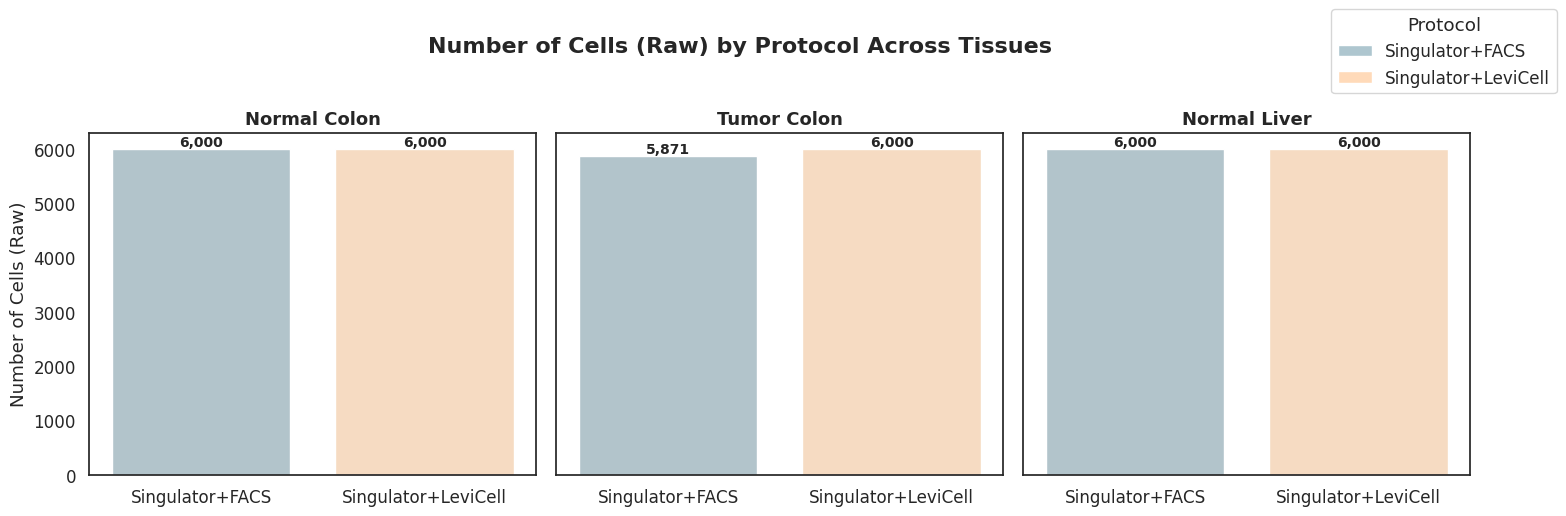

In [44]:
# Plot number of cells
fig = plot_adata_scalar_metric(
    plateau_adatas,
    adata_metadata=adata_metadata,
    metric_func=lambda adata: adata.n_obs,
    metric_label="Number of Cells (Raw)",
    protocol_color_palette=protocol_color_palette,
)

# Save the figure
fig.savefig(os.path.join(FIGURES_OUTPUT_DIR, "num_cells.png"), bbox_inches="tight")

### Plot Total UMIs

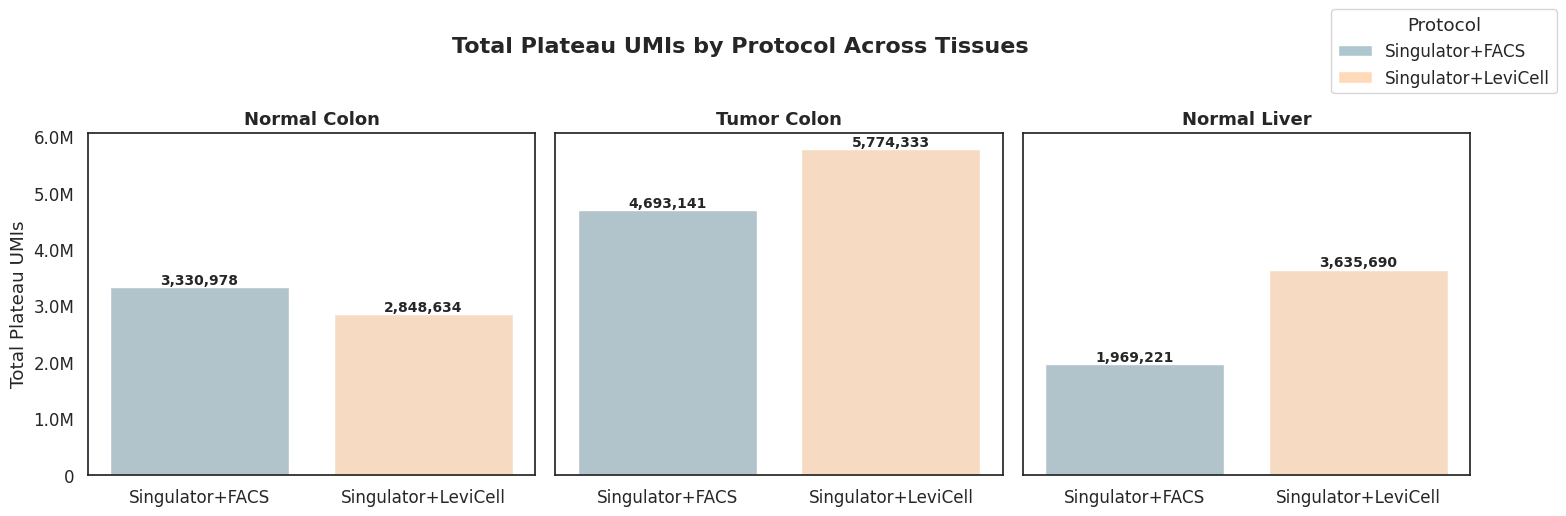

In [45]:
# Plot number of cells
fig = plot_adata_scalar_metric(
    plateau_adatas,
    adata_metadata=adata_metadata,
    metric_func=lambda adata: adata.X.sum(),
    metric_label="Total Plateau UMIs",
    protocol_color_palette=protocol_color_palette,
)

# Save the figure
fig.savefig(os.path.join(FIGURES_OUTPUT_DIR, "total_umis.png"), bbox_inches="tight")

In [ ]:
# Plot number of cells
fig = plot_adata_scalar_metric(
    plateau_adatas_cellbender,
    adata_metadata=adata_metadata,
    metric_func=lambda adata: adata.layers["cellbender"].sum(),
    metric_label="Total UMIs (CellBender Corrected)",
    protocol_color_palette=protocol_color_palette,
)

# Save the figure
fig.savefig(os.path.join(FIGURES_OUTPUT_DIR, "total_umis.png"), bbox_inches="tight")

### Plot Library Size Distribution

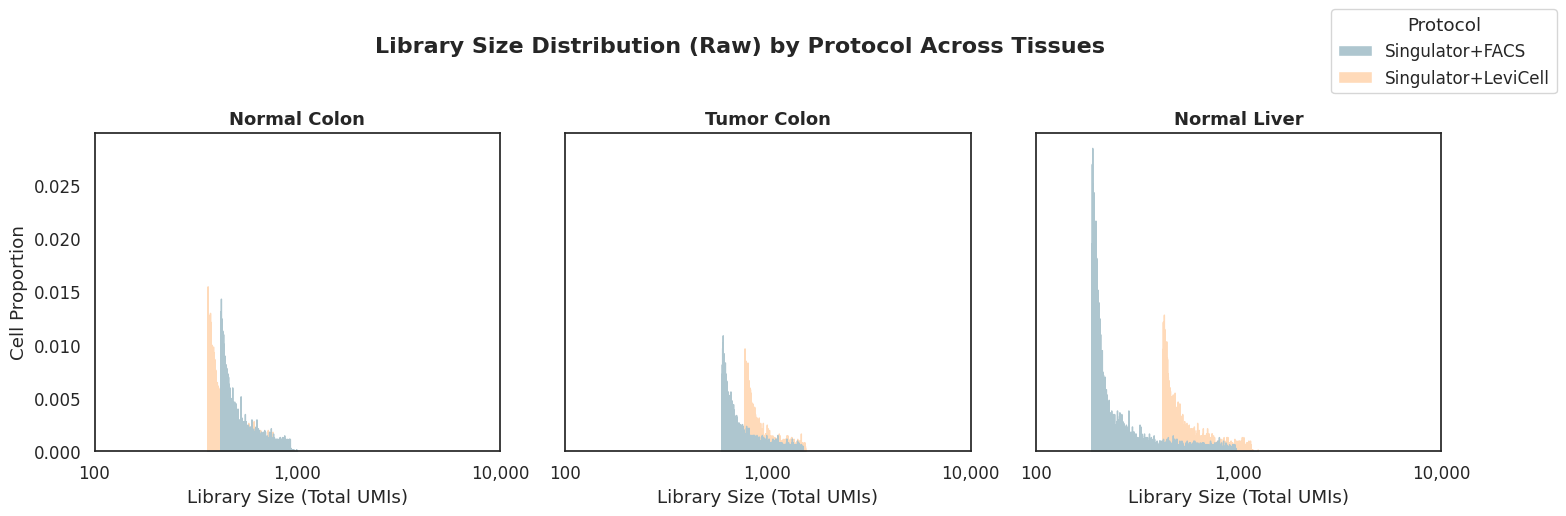

In [46]:
# Plot number of cells
fig = plot_adata_metric_histogram(
    plateau_adatas,
    adata_metadata=adata_metadata,
    field="total_counts",
    axis="obs",
    log_x=True,
    x_label="Library Size (Total UMIs)",
    title="Library Size Distribution (Raw) by Protocol Across Tissues",
    protocol_color_palette=protocol_color_palette,
    proportion=True,
    bins=5000,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "library_size_hist.png"), bbox_inches="tight"
)

count    6000.000000
mean        0.124979
std         0.296669
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.966771
Name: Value, dtype: float64
count    12000.000000
mean         0.127050
std          0.296816
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.976393
Name: Value, dtype: float64
count    18000.000000
mean         0.128361
std          0.289569
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.976393
Name: Value, dtype: float64
count    24000.000000
mean         0.124732
std          0.285439
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.976393
Name: Value, dtype: float64
count    30000.000000
mean         0.118815
std          0.275208
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.976393
Name: Value, dty

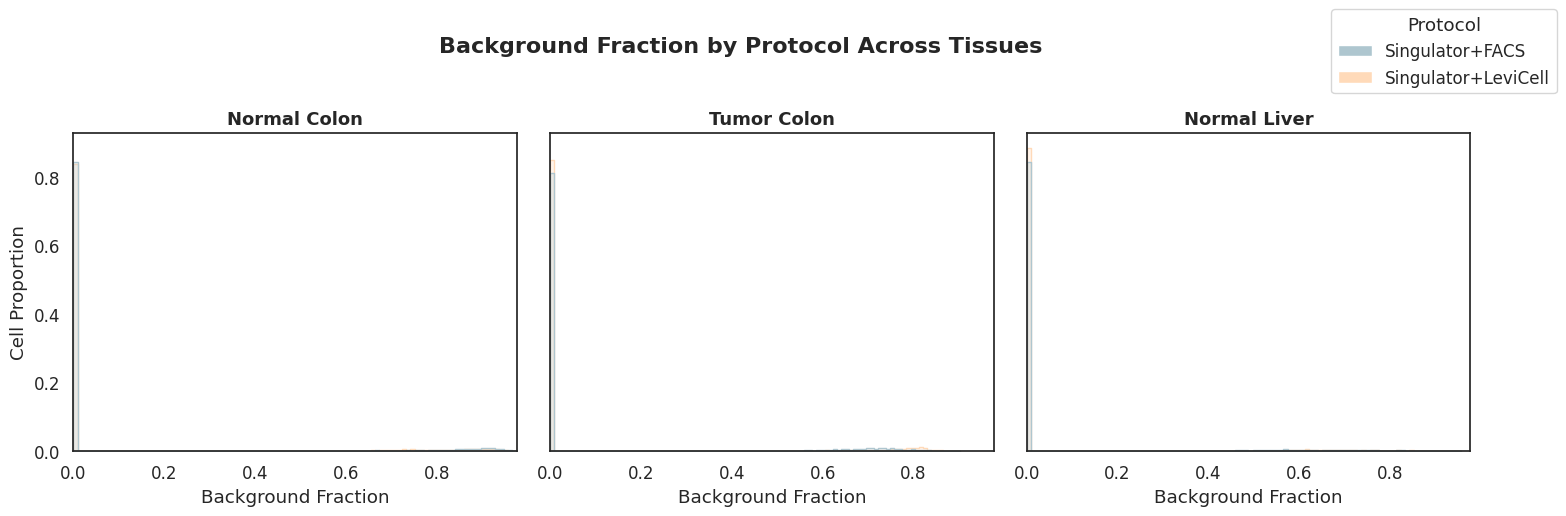

In [90]:
# Plot number of cells
fig = plot_adata_metric_histogram(
    plateau_adatas,
    adata_metadata=adata_metadata,
    field="background_fraction",
    axis="obs",
    log_x=False,
    x_label="Background Fraction",
    title="Background Fraction by Protocol Across Tissues",
    protocol_color_palette=protocol_color_palette,
    proportion=True,
    bins=100,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "library_size_hist.png"), bbox_inches="tight"
)

In [92]:
high_background = high_background_fraction_adatas["SF_LN"]
plateau_example = plateau_adatas["SF_LN"]

len(set(high_background.obs_names) & set(plateau_example.obs_names))

732

In [99]:
ambient_genes = plateau_example.var["ambient_expression"].sort_values(ascending=False)[
    :50
]
# plateau_example

In [100]:
with open(os.path.join(GENE_SETS_DIR, "housekeeping_genes.txt")) as f:
    housekeeping_genes = f.read().splitlines()

In [102]:
# len(set(ambient_genes.index) & set(housekeeping_genes))
ambient_genes.index

Index(['MALAT1', 'ALB', 'CPS1', 'ZBTB20', 'SLC26A3', 'LINC-PINT', 'CP', 'ELL2',
       'HSP90AA1', 'NEAT1', 'MT-ND3', 'MT-CO3', 'RORA', 'GPHN', 'LRMDA',
       'FKBP5', 'MT-ATP6', 'A2M', 'PPARGC1A', 'SORBS2', 'MT-CO1', 'MT-ND4',
       'EXT1', 'SOX5', 'MT-CO2', 'DPYD', 'CFH', 'GHR', 'FOXP1', 'ESR1', 'LPP',
       'FNDC3B', 'ZBTB16', 'SIK2', 'NFIA', 'FOXO1', 'MT-CYB', 'LDB2', 'GPC6',
       'XIST', 'NAMPT', 'AKAP13', 'MBNL1', 'ADK', 'PID1', 'MYO1B', 'SLC7A2',
       'ITPR2', 'PDE3B', 'SIK3'],
      dtype='object', name='gene_name')

In [51]:
adata = plateau_adatas["SF_N"]
adata.obs["background_fraction"].describe()

count    6000.000000
mean        0.133202
std         0.303210
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.966771
Name: background_fraction, dtype: float64

In [ ]:
# Plot number of cells
fig = plot_adata_metric_histogram(
    plateau_adatas_cellbender,
    adata_metadata=adata_metadata,
    field="total_counts",
    axis="obs",
    log_x=True,
    x_label="Library Size (Total UMIs)",
    title="Library Size Distribution (CellBender Corrected) by Protocol Across Tissues",
    protocol_color_palette=protocol_color_palette,
    proportion=True,
    bins=5000,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "library_size_hist.png"), bbox_inches="tight"
)

In [ ]:
adata = plateau_adatas_raw["SF_T"]
adata.obs["total_counts"]

In [ ]:
# Plot number of cells
fig = plot_adata_metric_violin(
    adatas,
    adata_metadata=adata_metadata,
    field="total_counts",
    axis="obs",
    y_label="Library Size (Total UMIs)",
    title="Library Size (Total UMIs) Distribution by Protocol Across Tissues",
    log_y=False,
    protocol_color_palette=protocol_color_palette,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "library_size_violin.png"), bbox_inches="tight"
)

### Plot Number of Genes per Cell

In [ ]:
# Plot number of genes per cell
fig = plot_adata_metric_histogram(
    plateau_adatas,
    adata_metadata=adata_metadata,
    field="n_genes_by_counts",
    axis="obs",
    log_x=False,
    x_label="Number of Genes per Cell",
    title="Number of Genes per Cell Distribution by Protocol Across Tissues",
    protocol_color_palette=protocol_color_palette,
    proportion=True,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "genes_per_cell_hist.png"), bbox_inches="tight"
)

In [ ]:
# Plot number of cells
fig = plot_adata_metric_violin(
    plateau_adatas,
    adata_metadata=adata_metadata,
    field="n_genes_by_counts",
    axis="obs",
    y_label="Number of Genes per Cell",
    title="Number of Genes per Cell Distribution by Protocol Across Tissues",
    log_y=False,
    protocol_color_palette=protocol_color_palette,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "genes_per_cell_violin.png"), bbox_inches="tight"
)

### Gene Detection

In [ ]:
# Plot number of cells per gene
fig = plot_adata_metric_histogram(
    plateau_adatas,
    adata_metadata=adata_metadata,
    field="n_cells_by_counts",
    axis="var",
    log_x=False,
    log_y=True,
    x_label="Number of Cells",
    title="Gene Detection Across Cells",
    protocol_color_palette=protocol_color_palette,
    proportion=True,
)

# Save the figure
fig.savefig(os.path.join(FIGURES_OUTPUT_DIR, "gene_detection.png"), bbox_inches="tight")

## Compute Mitochondiral and Ribosomal Gene Count Percentages

### Functions

In [ ]:
def compute_mito_qc_metrics(adatas: dict, pattern: str | List | tuple = "MT-") -> None:
    """
    Annotate mitochondrial genes and compute QC metrics for each AnnData in the dict.

    Args:
        adatas: dict with keys like 'sf_t', 'sl_t', etc. and values as AnnData objects
    """
    for adata in adatas.values():
        adata.var["mitochondrial"] = adata.var_names.str.startswith(pattern)
        sc.pp.calculate_qc_metrics(
            adata,
            qc_vars=["mitochondrial"],
            percent_top=None,
            log1p=False,
            inplace=True,
        )
    return


def compute_ribo_qc_metrics(
    adatas: dict, pattern: str | List | tuple = ("RPS", "RPL")
) -> None:
    """
    Annotate ribosomal genes and compute QC metrics for each AnnData in the dict.

    Args:
        adatas: dict with keys like 'sf_t', 'sl_t', etc. and values as AnnData objects
    """
    for adata in adatas.values():
        adata.var["ribosomal"] = adata.var_names.str.startswith(pattern)
        sc.pp.calculate_qc_metrics(
            adata, qc_vars=["ribosomal"], percent_top=None, log1p=False, inplace=True
        )
    return


compute_mito_qc_metrics(plateau_adatas, pattern="MT-")
compute_ribo_qc_metrics(plateau_adatas, pattern=("RPS", "RPL"))

### Plot Mitochondria Results

In [ ]:
# Plot mitochondrial content percentage
fig = plot_adata_metric_histogram(
    plateau_adatas,
    adata_metadata=adata_metadata,
    field="pct_counts_mitochondrial",
    axis="obs",
    log_x=False,
    log_y=True,
    x_label="Mitochondrial Content (%)",
    title="Mitochondrial Content per Cell Across Protocols and Tissues",
    protocol_color_palette=protocol_color_palette,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "mitochondrial_percentage_hist.png"),
    bbox_inches="tight",
)

In [ ]:
# Plot mitochondrial content percentage
fig = plot_adata_metric_violin(
    plateau_adatas,
    adata_metadata=adata_metadata,
    field="pct_counts_mitochondrial",
    axis="obs",
    log_y=False,
    y_label="Mitochondrial Content (%)",
    title="Mitochondrial Content per Cell Across Protocols and Tissues",
    protocol_color_palette=protocol_color_palette,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "mitochondrial_percentage_violin.png"),
    bbox_inches="tight",
)

### Plot Ribosomal Results

In [ ]:
# Plot ribosomal content percentage
fig = plot_adata_metric_histogram(
    plateau_adatas,
    adata_metadata=adata_metadata,
    field="pct_counts_ribosomal",
    axis="obs",
    log_x=False,
    log_y=False,
    x_label="Ribosomal Content (%)",
    title="Ribosomal Content per Cell Across Protocols and Tissues",
    protocol_color_palette=protocol_color_palette,
    proportion=True,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "ribosomal_percentage_hist.png"),
    bbox_inches="tight",
)

In [ ]:
# Plot ribosomal content percentage
fig = plot_adata_metric_violin(
    plateau_adatas,
    adata_metadata=adata_metadata,
    field="pct_counts_ribosomal",
    axis="obs",
    log_y=False,
    y_label="Ribosomal Content (%)",
    title="Ribosomal Content per Cell Across Protocols and Tissues",
    protocol_color_palette=protocol_color_palette,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "ribosomal_percentage_violin.png"),
    bbox_inches="tight",
)

## Compare Gene Set Content

### Functions

In [ ]:
def add_gene_set_content_to_adatas(
    adatas: dict, gene_set: list, gene_set_name: str
) -> None:
    """
    Annotate and compute percent content for a specific gene set (e.g. apoptosis or housekeeping)
    across all AnnData objects in a dictionary.

    Args:
        adatas: dict of AnnData objects keyed by sample label
        gene_set: list of gene symbols representing the gene set
        gene_set_name: string label for the gene set (e.g., 'apoptosis', 'housekeeping')
    """
    for adata in adatas.values():
        filtered_genes = list(set(gene_set) & set(adata.var_names))
        print(
            f"{adata.obs.shape[0]} cells | {len(filtered_genes)} {gene_set_name} genes found"
        )

        # Mark genes belonging to the gene set
        adata.var[gene_set_name] = adata.var_names.isin(filtered_genes)

        # Calculate percent content using scanpy
        sc.pp.calculate_qc_metrics(
            adata, qc_vars=[gene_set_name], percent_top=None, log1p=False, inplace=True
        )

### Run functions

In [ ]:
# Load apoptosis gene list (from Rahul)
with open(os.path.join(GENE_SETS_DIR, "apoptosis_genes.txt")) as f:
    apoptosis_genes = f.read().splitlines()

# Load housekeeping gene list from (https://www.gsea-msigdb.org/gsea/msigdb/cards/HOUNKPE_HOUSEKEEPING_GENES)
with open(os.path.join(GENE_SETS_DIR, "housekeeping_genes.txt")) as f:
    housekeeping_genes = f.read().splitlines()

# Annotate and compute
add_gene_set_content_to_adatas(
    plateau_adatas, apoptosis_genes, gene_set_name="apoptosis"
)
add_gene_set_content_to_adatas(
    plateau_adatas, housekeeping_genes, gene_set_name="housekeeping"
)

### Plot Apoptosis Results

In [ ]:
# Plot apoptosis content percentage
fig = plot_adata_metric_histogram(
    plateau_adatas,
    adata_metadata=adata_metadata,
    field="pct_counts_apoptosis",
    axis="obs",
    log_x=False,
    log_y=False,
    x_label="Apoptosis Content (%)",
    title="Apoptosis Content per Cell Across Protocols and Tissues",
    protocol_color_palette=protocol_color_palette,
    proportion=True,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "apoptosis_percentage_hist.png"),
    bbox_inches="tight",
)

In [ ]:
# Plot apoptosis content percentage
fig = plot_adata_metric_violin(
    plateau_adatas,
    adata_metadata=adata_metadata,
    field="pct_counts_apoptosis",
    axis="obs",
    log_y=False,
    y_label="Apoptosis Content (%)",
    title="Apoptosis Content per Cell Across Protocols and Tissues",
    protocol_color_palette=protocol_color_palette,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "apoptosis_percentage_violin.png"),
    bbox_inches="tight",
)

### Plot Housekeeping Results

In [ ]:
# Plot housekeeping content percentage
fig = plot_adata_metric_histogram(
    plateau_adatas,
    adata_metadata=adata_metadata,
    field="pct_counts_housekeeping",
    axis="obs",
    log_x=False,
    log_y=False,
    x_label="Housekeeping Content (%)",
    title="Housekeeping Content per Cell Across Protocols and Tissues",
    protocol_color_palette=protocol_color_palette,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "housekeeping_percentage_hist.png"),
    bbox_inches="tight",
)

In [ ]:
# Plot housekeeping content percentage
fig = plot_adata_metric_violin(
    plateau_adatas,
    adata_metadata=adata_metadata,
    field="pct_counts_housekeeping",
    axis="obs",
    log_y=False,
    y_label="Housekeeping Content (%)",
    title="Housekeeping Content per Cell Across Protocols and Tissues",
    protocol_color_palette=protocol_color_palette,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "housekeeping_percentage_violin.png"),
    bbox_inches="tight",
)

In [ ]:
# Plot housekeeping content percentage
fig = plot_adata_metric_histogram(
    plateau_adatas,
    adata_metadata=adata_metadata,
    field="background_fraction",
    axis="obs",
    log_x=False,
    log_y=False,
    proportion=True,
    x_label="Background Fraction",
    title="Background Fraction per Cell Across Protocols and Tissues",
    protocol_color_palette=protocol_color_palette,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "background_fraction.png"),
    bbox_inches="tight",
)

In [ ]:
def plot_obs_scatter_by_tissue(
    adatas: Dict[str, sc.AnnData],
    adata_metadata: Dict[str, tuple],
    x_field: str,
    y_field: str,
    log_x: bool = True,
    log_y: bool = False,
    title: str = "Scatter Plot of Obs Fields by Tissue",
    protocol_color_palette: Dict[str, str] = None,
    shuffle: bool = True,
) -> plt.Figure:
    """
    Plots scatter plot of two obs fields for each AnnData object, grouped by tissue.

    Args:
        adatas: Dictionary of AnnData objects.
        adata_metadata: Dictionary mapping keys in adatas to (tissue, protocol).
        x_field: Field in adata.obs for x-axis.
        y_field: Field in adata.obs for y-axis.
        log_x: Apply log1p to x-axis values.
        log_y: Apply log1p to y-axis values.
        title: Plot title.
        protocol_color_palette: Optional dictionary for protocol-specific colors.
        shuffle: If True, shuffle the data points to avoid overlap in scatter plot.

    Returns:
        matplotlib Figure object.
    """
    rows = []
    for key, adata in adatas.items():
        tissue, protocol = adata_metadata[key]
        x = adata.obs[x_field]
        y = adata.obs[y_field]
        if log_x:
            x = np.log1p(x)
        if log_y:
            y = np.log1p(y)
        for xi, yi in zip(x, y):
            rows.append(
                {"Tissue": tissue, "Protocol": protocol, x_field: xi, y_field: yi}
            )
    df = pd.DataFrame(rows)

    if shuffle:
        df = df.sample(frac=1, random_state=0).reset_index(drop=True)

    unique_tissues = df["Tissue"].unique()
    sns.set_theme(style="white", font_scale=1.1)
    fig, axes = plt.subplots(
        1, len(unique_tissues), figsize=(5 * len(unique_tissues), 5), sharey=True
    )
    if len(unique_tissues) == 1:
        axes = [axes]

    for i, tissue in enumerate(unique_tissues):
        ax = axes[i]
        df_subset = df[df["Tissue"] == tissue]
        if shuffle:
            df_subset = df_subset.sample(frac=1, random_state=0).reset_index(drop=True)
        sns.scatterplot(
            data=df_subset,
            x=x_field,
            y=y_field,
            hue="Protocol",
            palette=protocol_color_palette,
            alpha=0.8,
            size=0.8,
            ax=ax,
            legend=False,
            linewidth=0,
        )
        ax.set_title(tissue, fontsize=13, weight="bold")
        ax.set_xlabel(f"log1p({x_field})" if log_x else x_field)
        if i == 0:
            ax.set_ylabel(f"log1p({y_field})" if log_y else y_field)
        else:
            ax.set_ylabel("")

    plt.suptitle(title, fontsize=16, weight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    return fig

In [ ]:
fig = plot_obs_scatter_by_tissue(
    adatas=plateau_adatas,
    adata_metadata=adata_metadata,
    x_field="total_counts",
    y_field="background_fraction",
    log_x=True,
    log_y=False,
    title="Library Size vs Background Fraction by Tissue",
    protocol_color_palette=protocol_color_palette,
)

In [ ]:
fig = plot_obs_scatter_by_tissue(
    adatas=plateau_adatas,
    adata_metadata=adata_metadata,
    x_field="pct_counts_housekeeping",
    y_field="background_fraction",
    log_x=True,
    log_y=False,
    title="Library Size vs Background Fraction by Tissue",
    protocol_color_palette=protocol_color_palette,
)

In [ ]:
# Plot housekeeping content percentage
fig = plot_adata_metric_histogram(
    plateau_adatas,
    adata_metadata=adata_metadata,
    field="background_fraction",
    axis="obs",
    log_x=False,
    log_y=False,
    x_label="Background Fraction",
    title="Background Fraction per Cell Across Protocols and Tissues",
    protocol_color_palette=protocol_color_palette,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "background_fraction_hist.png"),
    bbox_inches="tight",
)

## Save AnnDatas to File

In [ ]:
# Save each AnnData object to file in the analysis directory
for key, (folder, tissue, protocol) in samples.items():
    out_path = os.path.join(OUTPUT_ADATA_DIR, f"{key}_adata.h5ad")
    adatas[key].write(out_path)
    print(f"Saved {key}_adata to {out_path}")

In [ ]:
# Load AnnData objects
adata_no_filter = {}
adata_metadata = {}
adata_tissues = []

for key, (folder, tissue, protocol) in samples.items():
    input_file_path = os.path.join(
        READ_ONLY_DIR,
        folder,
        f"analyses/CellRangerGex-9.0.0-{folder}/outputs",
        RAW_FEATURE_BC_MATRIX_FILE_NAME,
    )
    output_file_path = os.path.join(
        INPUT_ADATA_DIR, f"{key}_cell_bender_corrected_output_filtered.h5"
    )
    output_file_path = os.path.join(
        DATA_DIR,
        "analysis",
        key,
        "cell_bender",
        f"{key}_cell_bender_corrected_output.h5",
    )
    adata = load_anndata_from_input_and_output(
        input_file=input_file_path, output_file=output_file_path, input_layer_key="raw"
    )
    adata_no_filter[key] = adata
    adata_metadata[key] = (tissue, protocol)
    adata_tissues.append(tissue)
    print(f"{key}: {adata}")

In [ ]:
adata_subset = {}

for key, adata in adata_no_filter.items():
    prob = adata.obs["posterior_probability_cell"]

    # High confidence cells (>0.5), sorted descending
    high_conf_mask = prob > 0.5
    high_conf_cells = prob[high_conf_mask].sort_values(ascending=False).head(1000).index

    # Low confidence cells (≤0.5), sorted ascending
    low_conf_mask = prob <= 0.5
    low_conf_cells = prob[low_conf_mask].sort_values().head(5000).index

    # Combine indices and subset
    selected_cells = high_conf_cells.union(low_conf_cells)
    adata_subset[key] = adata[selected_cells].copy()

    print(
        f"{key}: retained {len(selected_cells)} cells "
        f"({len(high_conf_cells)} high prob, {len(low_conf_cells)} low prob)"
    )